# Advanced Techniques for Lane Finding

> Discover more advanced computer vision techniques to improve upon your lane lines algorithm!

In [1]:
import numpy as np
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
IMG_ROOT = 'images/19-Advanced-Techniques'

## Reviewing Steps

Steps:
1. Camera calibration              校准镜头
2. Distortion correction            去除图像的畸变
3. Color & Gradient Threshold 使用颜色和梯度阈值
4. Perspective transform          透视变换
5. Detect lane lines 
6. Determine the lane curvature

## Processing Each Image
首先计算 `camera calibration matrix` 和`distortion coefficients`，只需要计算一次，就可以应用它们去校正每一帧图片。

### Tresholding
然后尝试使用不同`color and gradient thresholds` 的组合来生成清晰的车道线 binary image。
<img src='images/19-Advanced-Techniques/binary-combo-img.jpg'>

### Perspective Transform
<img src='images/19-Advanced-Techniques/warped-straight-lines.jpg'>


### Curved Lines
<img src='images/19-Advanced-Techniques/warped-curved-lines.jpg'>

## Finding the Lines: Histogram Peaks



<img src='images/19-Advanced-Techniques/warped-example.jpg' width=300>


当对 road image 应用 `calibration`, `thresholding`, 和 `perspective transform` 技术后, *车道线* 可以在二值化图清晰的显示出来。然而，还需要检测哪些像素是属于车道线。以及如何区分车道线是在汽车左侧还是右侧。

In [3]:
def hist(img):
    img_h = img.shape[0]

    # 只需对底部的半张图片进行直方图
    bottom_half = img[img_h // 2:, :]
    
    # Sum across image pixels vertically - make sure to set an 'axis'
    # i.e. the highest areas of vertical lines should be larger values.
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

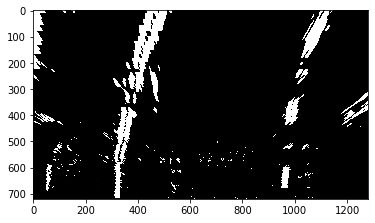

In [8]:
fpath = os.path.join(IMG_ROOT, 'warped-example.jpg')
image = mpimg.imread(fpath) / 255
plt.imshow(image, cmap='gray')

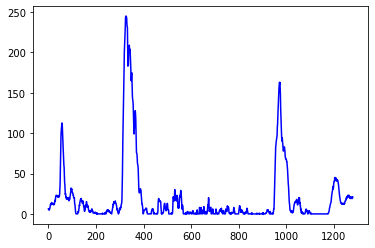

In [9]:
histogram = hist(image)
plt.plot(histogram, color='blue')

## Finding the lines: Sliding Windows

<img src = 'images/19-Advanced-Techniques/sw1.png' width=400>
<img src = 'images/19-Advanced-Techniques/sw2.png' width=400>
<img src = 'images/19-Advanced-Techniques/sw3.png' width=400>
<img src = 'images/19-Advanced-Techniques/sw4.png' width=400>
<img src = 'images/19-Advanced-Techniques/sw5.png' width=400>
<img src = 'images/19-Advanced-Techniques/sw6.png' width=400>

### Implement Sliding Windows and Fit a Polynomial

we can use the **two highest peaks** from our histogram as a **starting point** for determining where the lane lines are, and then use sliding windows moving upward in the image(further along the road) to determine where the lane lines go.

**(1) Split the histogram for the two lines**
```python
bottom_half = binary_warped[binary_warped.shape[0]//2:, :]
histogram = np.sum(bottom_half, axis=0)

# create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
```

**(2) Set up windows and window hyperparameters**
```python
# choose the number of sliding windows
nwindows = 9

# set the width of the windows +/- margin
margin = 100

# set minimum number of pixels found to recenter window
minpix = 50

# set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzeros pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []
```

**(3) Iterate through `nwindows` to track curvature**


**(4) Fit a polynomial**
```python
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Assuming we have 'left_fit' and 'right_fit' from 'np.polyfit' before
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
```

**(5) Visualization**
```python
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
```

In [18]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low   = leftx_current - margin    # Update this
        win_xleft_high  = leftx_current + margin    # Update this
        win_xright_low  =  rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin   # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, 
                      (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), 
                      (0,255,0), 2) 
        cv2.rectangle(out_img, 
                      (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), 
                      (0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [19]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

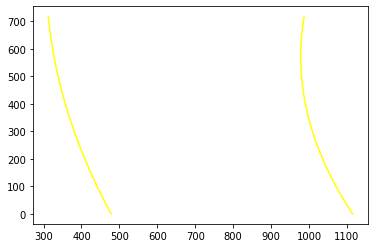

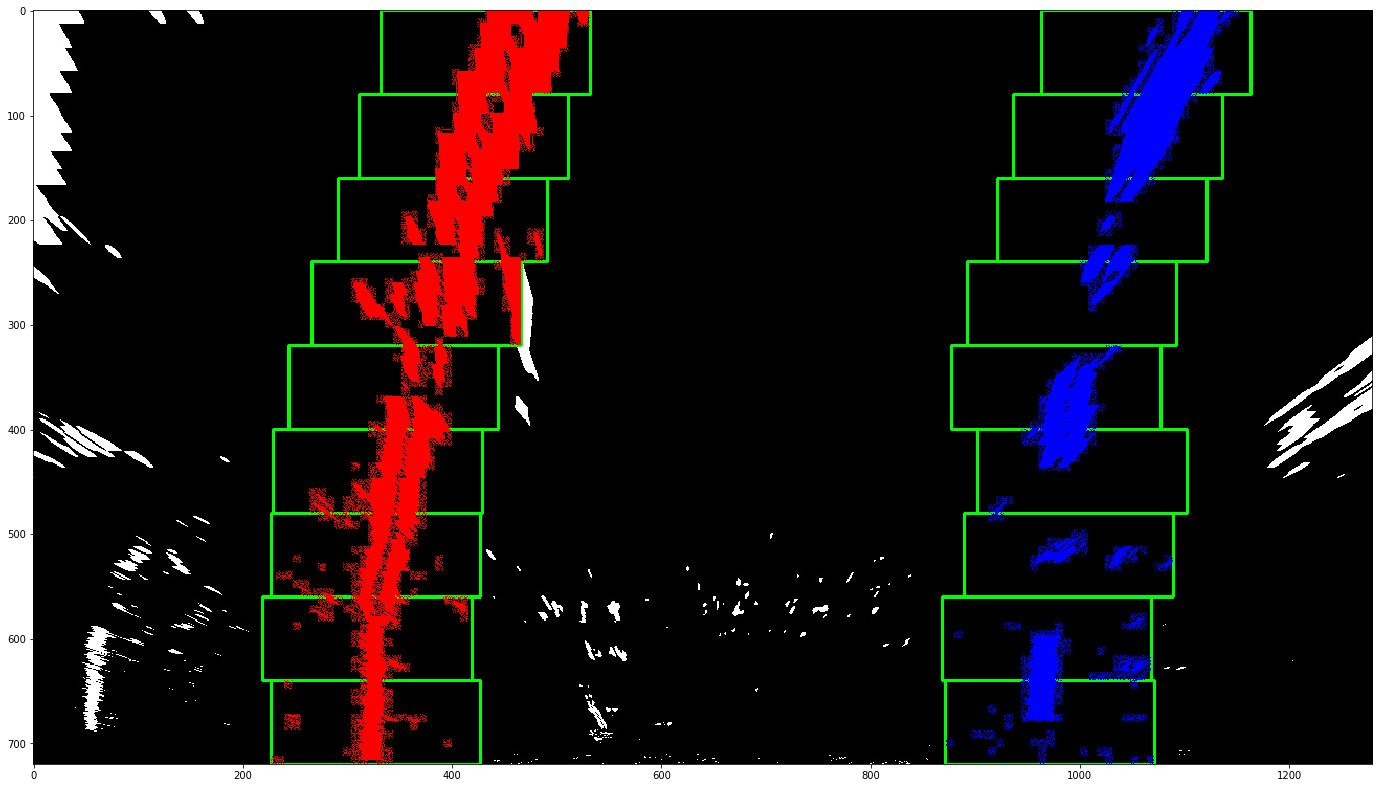

In [20]:
# Load our image
fpath = os.path.join(IMG_ROOT, 'warped-example.jpg')
binary_warped = mpimg.imread(fpath)
out_img = fit_polynomial(binary_warped)
plt.figure(figsize=(24, 20))
plt.imshow(out_img)

## Search from Prior

In [26]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_fitx = left_fit[0] * (nonzeroy**2) + left_fit[1] * nonzeroy + left_fit[2]
    left_lane_inds = ((nonzerox > left_fitx - margin) & 
                      (nonzerox < left_fitx + margin))
    
    right_fitx = right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2]
    right_lane_inds = ((nonzerox > right_fitx - margin) &
                       (nonzerox < right_fitx + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    # 左车道线设为红色, 右车道线设为蓝色
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    return result

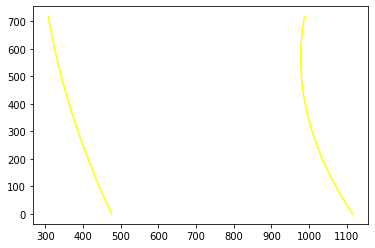

In [27]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

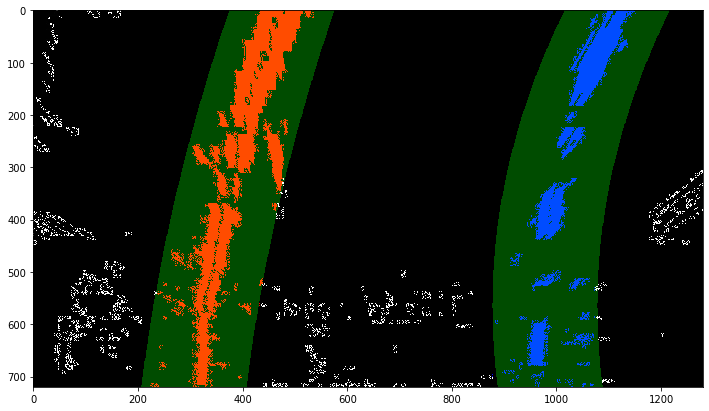

In [30]:
# View your output
plt.figure(figsize=(12, 10))
plt.imshow(result)

## Measuring Curvature

<img src='images/19-Advanced-Techniques/color-fit-lines.jpg'>

上面，已经定位了车道线的像素，使用`x`和`y`像素的位置来拟合二阶多项式曲线

$f(y) = Ay^2 + By + C$

注意, 拟合的是$f(y)$, 而不是$f(x)$, 因为车道线在`warped image`是接近于垂直, 因此对于一个`y`值, 可能有相同的`x`value

### Radius of Curvature
方程$x = f(y)$, 对于任一点的 $x$, 曲线的半径计算如下:

$R_{curve} = \frac{[1+(\frac{dx}{dy})^2]^{3/2}}{|\frac{d^{2}x}{dy^2}|}$

对于二次多项式，一阶和二阶导数如下:

$\dot{f(y)} = \frac{dx}{dy} = 2Ay + B$

$\ddot{f(y)} = \frac{d^{2}x}{dy^2}$ = 2A

因此, 曲线半径的等式等价于:

$R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{|2A|}$

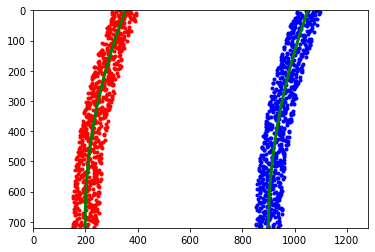

In [32]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)

right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [33]:
import numpy as np

def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit

def calculate_curve_radius(A, B, y):
    return (1 + (2*A*y + B)**2)**1.5 / (2 * np.absolute(A))
    
def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = calculate_curve_radius(left_fit[0], left_fit[1], y_eval)  
    right_curverad = calculate_curve_radius(right_fit[0], right_fit[1], y_eval)
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number


1625.060183165725 1976.296730771462


### From pixels to Real-World

[U.S. government specifications for highway curvature ](http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC)

In [35]:
def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr

    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [36]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

533.7525889210925 m 648.1574851434334 m
